## Question 1
To find the subdifferetial  of SVM, we use the affine transformation rule:

$$f(\omega,b) = \frac{1}{n} \sum_{i=1}^{n} (1-y_i(<\omega,x_i>+b))_+ + \frac{\lambda}{2}||\omega||_2^2\\
= \frac{1}{n} \sum_{i=1}^{n} (1-y_i(\omega^Tx_i+b))_+ + \frac{\lambda}{2}||\omega||_2^2\\
\textrm{Let } h_i(\omega) = (1-y_i\omega^Tx_i-y_ib)_+\\
\partial h_i(\omega) = -y_ix_i \cdot \partial p(z) |_{z = 1-y_ix_i^T\omega-y_ib}\\
 = -y_ix_i \left \{ \begin{array}{ll}
0, & \text{ if }\text{\(1-y_i\omega^Tx_i<y_ib\)}\\
1, & \text{ if } \text{\(1-y_i\omega^Tx_i>y_ib\)}\\
[0,1], & \text{ if } \text{\(1-y_i\omega^Tx_i=y_ib\)}
\end{array} \right.\\
\partial f(\omega) = \frac{1}{n} \sum_{i = 1}^{n} -y_ix_i \left \{ \begin{array}{ll}
0, & \text{ if }\text{\(1-y_i\omega^Tx_i<y_ib\)}\\
1, & \text{ if } \text{\(1-y_i\omega^Tx_i>y_ib\)}\\
[0,1], & \text{ if } \text{\(1-y_i\omega^Tx_i=y_ib\)}
\end{array} \right. + \lambda \omega\\
\partial h_i(b) = -y_i \cdot \partial p(z) |_{z = 1-y_ix_i^T\omega-y_ib}\\
=-y_i \left \{ \begin{array}{ll}
0, & \text{ if }\text{\(1-y_i\omega^Tx_i<y_ib\)}\\
1, & \text{ if } \text{\(1-y_i\omega^Tx_i>y_ib\)}\\
[0,1], & \text{ if } \text{\(1-y_i\omega^Tx_i=y_ib\)}
\end{array} \right.\\
\partial f(b) = -y_i \left \{ \begin{array}{ll}
0, & \text{ if }\text{\(1-y_i\omega^Tx_i<y_ib\)}\\
1, & \text{ if } \text{\(1-y_i\omega^Tx_i>y_ib\)}\\
[0,1], & \text{ if } \text{\(1-y_i\omega^Tx_i=y_ib\)}
\end{array} \right.\\$$

In [1]:
import xml.sax

import numpy as np
import random
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils.random import sample_without_replacement

In [2]:
def sgdmethod(X, y, subgradloss, subgradreg, regparam, w1, T, a, m):
    record = list()
    index = [i for i in range(X.shape[0])]
    for t in range(T):
        alpha = 1/(1+a*(t+1))
        random.shuffle(index)
        mini_batch = index[0:m]
        reg_gradient = np.append(subgradreg(regparam,w1[0:-1]),0)
        gradient = (1/m)*sum([subgradloss(X[j],y[j],w1) for j in mini_batch])
        w1 = w1-alpha*(gradient+reg_gradient).reshape(-1,1)
        record.append(np.copy(w1))
    return record
def subgradloss(x,y,w):
    weight = w[0:-1]
    bias = w[-1]
    x = x.reshape(-1,1)
    weight = weight.reshape(-1,1)
    bias = bias.reshape(-1,1)
    partial_w = np.zeros(weight.shape)
    partial_b = np.zeros(bias.shape)
    cond = 1-(y*weight.T@x)-y*bias
    if cond>0:
        partial_w = np.array(-y*x.T)
        partial_b = np.array(-y)
    elif cond==0:
        partial_w = np.array(0.5*(-y*x.T))
        partial_b = np.array(-0.5*y)
    return np.append(partial_w,partial_b)
def subgradreg(regparam,w):
    return regparam*w

In [3]:
def inference(W,b,X):
    pred = W.T@X.T+b
    pred[pred>0] = 1
    pred[pred<0] = -1
    return pred
def accuracy(W,b,X,y):
    pred = inference(W,b,X)
    acc = np.sum(np.array(pred) == y,axis = 1).item()/(y.shape[0])
    return acc
def find_objective_heler(w,b,X,y,reg_term):
    temp = 1-(np.multiply(y,(w.T@X.T+b)))
    temp[temp<0] = 0
    return (np.sum(temp)/X.shape[0])+ (reg_term/2)*(w.T@w)

In [4]:
train = load_svmlight_file(f='a9a')
X_train = np.array(train[0].todense()[:,0:122])
y_train = train[1]
test = load_svmlight_file(f='a9a.t')
X_test = np.array(test[0].todense())
y_test = test[1]
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
training_set_size_t = 100
training_set_size_hist = sgdmethod(X_train_scaled,y_train,subgradloss,subgradreg,1/(X_train_scaled.shape[0]),np.random.rand(X_train_scaled.shape[1]+1,1),training_set_size_t,0.07,X_train_scaled.shape[0])

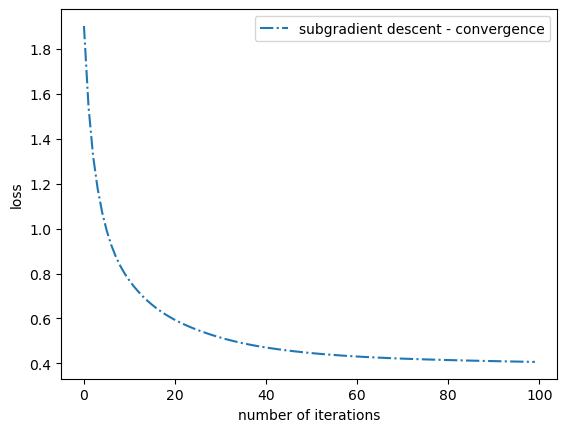

In [6]:
convergence = list()
for i in training_set_size_hist:
    convergence.append(find_objective_heler(i[0:-1],i[-1],X_train_scaled,y_train,1/(X_train_scaled.shape[0])).item())
plt.plot(range(len(convergence)), convergence, label = "subgradient descent - convergence", linestyle="-.")
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.legend()


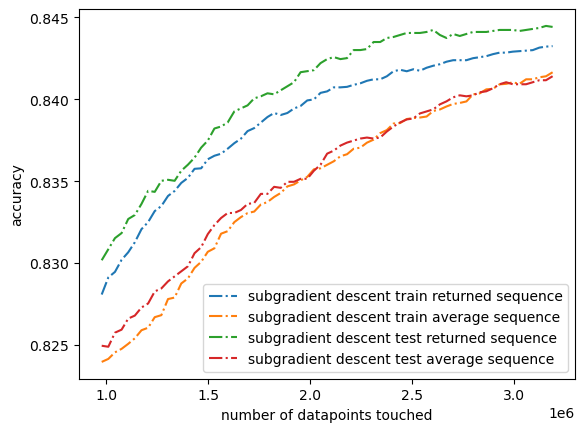

In [7]:
whole_dataset_num_data_points_touched = [X_train_scaled.shape[0]*i for i in range(training_set_size_t)]
whole_dataset_train_last_accuracy_hist = list()
whole_dataset_train_avg_accuracy_hist = list()
whole_dataset_test_last_accuracy_hist = list()
whole_dataset_test_avg_accuracy_hist = list()
for t,i in enumerate(training_set_size_hist):
    train_last_acc = accuracy(i[0:-1],i[-1],X_train_scaled,y_train)
    test_last_acc = accuracy(i[0:-1],i[-1],X_test_scaled,y_test)
    if t>=2:
        train_avg_acc = accuracy((1/(t-np.floor(t/2)+1))*np.sum([training_set_size_hist[j][0:-1] for j in range(int(np.floor(t/2)),t)],axis = 0),i[-1],X_train_scaled,y_train)
        test_avg_acc = accuracy((1/(t-np.floor(t/2)+1))*np.sum([training_set_size_hist[j][0:-1] for j in range(int(np.floor(t/2)),t)],axis = 0),i[-1],X_test_scaled,y_test)
    else:
        train_avg_acc = 0
        test_avg_acc = 0
    whole_dataset_train_last_accuracy_hist.append(train_last_acc)
    whole_dataset_train_avg_accuracy_hist.append(train_avg_acc)
    whole_dataset_test_last_accuracy_hist.append(test_last_acc)
    whole_dataset_test_avg_accuracy_hist.append(test_avg_acc)
plt.plot(whole_dataset_num_data_points_touched[30:-1], whole_dataset_train_last_accuracy_hist[30:-1], label = "subgradient descent train returned sequence", linestyle="-.")
plt.plot(whole_dataset_num_data_points_touched[30:-1], whole_dataset_train_avg_accuracy_hist[30:-1], label = "subgradient descent train average sequence", linestyle="-.")
plt.plot(whole_dataset_num_data_points_touched[30:-1], whole_dataset_test_last_accuracy_hist[30:-1], label = "subgradient descent test returned sequence", linestyle="-.")
plt.plot(whole_dataset_num_data_points_touched[30:-1], whole_dataset_test_avg_accuracy_hist[30:-1], label = "subgradient descent test average sequence", linestyle="-.")
plt.xlabel("number of datapoints touched")
plt.ylabel("accuracy")
plt.legend()

In [9]:
one_sample_t = 10000
one_sample_hist = sgdmethod(X_train_scaled,y_train,subgradloss,subgradreg,1/(X_train_scaled.shape[0]),np.random.rand(X_train_scaled.shape[1]+1,1),one_sample_t,0.08,1)

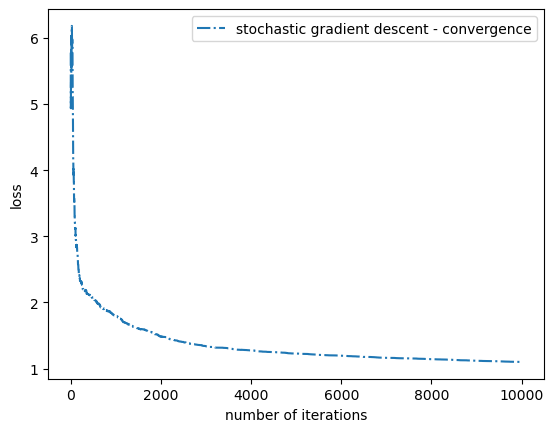

In [10]:
convergence = list()
for i in one_sample_hist:
    convergence.append(find_objective_heler(i[0:-1],i[-1],X_train_scaled,y_train,1/(X_train_scaled.shape[0])).item())
plt.plot(range(len(convergence)), convergence, label = "stochastic gradient descent - convergence", linestyle="-.")
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.legend()

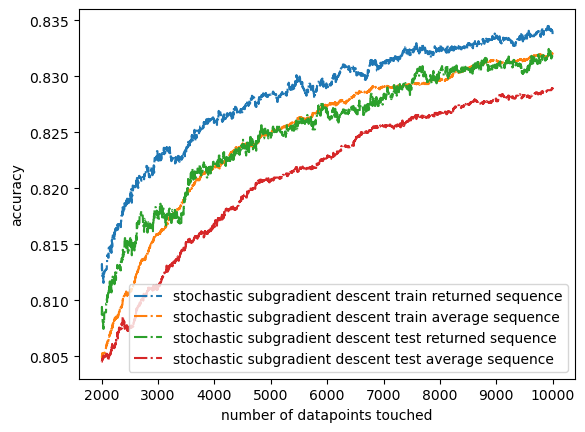

In [11]:
one_sample_num_data_points_touched = [i for i in range(one_sample_t)]
one_sample_train_last_accuracy_hist = list()
one_sample_train_avg_accuracy_hist = list()
one_sample_test_last_accuracy_hist = list()
one_sample_test_avg_accuracy_hist = list()
for t,i in enumerate(one_sample_hist):
    train_last_acc = accuracy(i[0:-1],i[-1],X_train_scaled,y_train)
    test_last_acc = accuracy(i[0:-1],i[-1],X_test_scaled,y_test)
    if t>=2:
        train_avg_acc = accuracy((1/(t-np.floor(t/2)+1))*np.sum([one_sample_hist[j][0:-1] for j in range(int(np.floor(t/2)),t)],axis = 0),i[-1],X_train_scaled,y_train)
        test_avg_acc = accuracy((1/(t-np.floor(t/2)+1))*np.sum([one_sample_hist[j][0:-1] for j in range(int(np.floor(t/2)),t)],axis = 0),i[-1],X_test_scaled,y_test)
    else:
        train_avg_acc = 0
        test_avg_acc = 0
    one_sample_train_last_accuracy_hist.append(train_last_acc)
    one_sample_train_avg_accuracy_hist.append(train_avg_acc)
    one_sample_test_last_accuracy_hist.append(test_last_acc)
    one_sample_test_avg_accuracy_hist.append(test_avg_acc)
plt.plot(one_sample_num_data_points_touched[2000:-1], one_sample_train_last_accuracy_hist[2000:-1], label = "stochastic subgradient descent train returned sequence", linestyle="-.")
plt.plot(one_sample_num_data_points_touched[2000:-1], one_sample_train_avg_accuracy_hist[2000:-1], label = "stochastic subgradient descent train average sequence", linestyle="-.")
plt.plot(one_sample_num_data_points_touched[2000:-1], one_sample_test_last_accuracy_hist[2000:-1], label = "stochastic subgradient descent test returned sequence", linestyle="-.")
plt.plot(one_sample_num_data_points_touched[2000:-1], one_sample_test_avg_accuracy_hist[2000:-1], label = "stochastic subgradient descent test average sequence", linestyle="-.")
plt.xlabel("number of datapoints touched")
plt.ylabel("accuracy")
plt.legend()

## Report the highest test accuracy for each of four methods along with the number of datapoints used to obtain those accuracies.


In [12]:
whole_dataset_test_last_best = max(whole_dataset_test_last_accuracy_hist)
whole_dataset_test_last_best_num_pts = whole_dataset_num_data_points_touched[np.argmax(whole_dataset_test_last_accuracy_hist)]
whole_dataset_test_avg_best = max(whole_dataset_test_avg_accuracy_hist)
whole_dataset_test_avg_best_num_pts = whole_dataset_num_data_points_touched[np.argmax(whole_dataset_test_avg_accuracy_hist)]
one_sample_test_last_best = max(one_sample_test_last_accuracy_hist)
one_sample_test_last_best_num_pts = one_sample_num_data_points_touched[np.argmax(one_sample_test_last_accuracy_hist)]
one_sample_test_avg_best = max(one_sample_test_avg_accuracy_hist)
one_sample_test_avg_best_num_pts = one_sample_num_data_points_touched[np.argmax(one_sample_test_avg_accuracy_hist)]
print(f"highest accuracy for subgradient descent with last model returned is {whole_dataset_test_last_best} with the number of data points equal to {whole_dataset_test_last_best_num_pts}")
print(f"highest accuracy for subgradient descent with averaged model is {whole_dataset_test_avg_best} with the number of data points equal to {whole_dataset_test_avg_best_num_pts}")
print(f"highest accuracy for stochastic subgradient descent with last model returned is {one_sample_test_last_best} with the number of data points equal to {one_sample_test_last_best_num_pts}")
print(f"highest accuracy for stochastic subgradient descent with averaged model is {one_sample_test_avg_best} with the number of data points equal to {one_sample_test_avg_best_num_pts}")

highest accuracy for subgradient descent with last model returned is 0.8444812972176157 with the number of data points equal to 3158417
highest accuracy for subgradient descent with averaged model is 0.8414102327866838 with the number of data points equal to 3190978
highest accuracy for stochastic subgradient descent with last model returned is 0.8324427246483631 with the number of data points equal to 9928
highest accuracy for stochastic subgradient descent with averaged model is 0.8289417111971009 with the number of data points equal to 9986


## What observations do you have about the performance of sgd and the subgradient method, and the impact of averaging?
It takes fewer iterations and time for the subgradient method to converge. But it takes less number of data points touched for the stochastic subgradient method to converge and reach a similar accuracy. Averaging the model with previous models drag the accuracy down as previous models might have higher objective values and lower accuracy

## Question 2
### part 1
The geometric intuition is we need to find a point u in the constrained set C such that we are taking a step in a way that reduces the function value and makes sure u and X_t are close at the same time.
We can formulate this constrained optimization problem into the projected subgradient method with step size equal to $\alpha_t$ by removing constants and completing the squares.
\begin{align*}
X_{t+1} =& \underset{u \in C} {\operatorname{argmin}} f(X_t) + <g,u-X_t>+\frac{1}{2 \alpha_t}||u-X_t||_2^2\\
&\textrm{We can remove $f(X_t)$ from the objective as it's a constant}\\
=& \underset{u \in C} {\operatorname{argmin}} g^T(u-X_t) + \frac{1}{2 \alpha_t}(u-X_t)^T(u-X_t)\\
&\textrm{We can multiply the objective by $2 \alpha_t$ as it's a constant}\\
=& \underset{u \in C} {\operatorname{argmin}} 2 \alpha_t g^T(u-X_t)+(u-X_t)^T(u-X_t)\\
&\textrm{We can add $\alpha_t^2g^Tg$ to the objective as it's a constant}\\
=& \underset{u \in C} {\operatorname{argmin}} \alpha_t g^T(u-X_t)+ \alpha_t g^T(u-X_t)+(u-X_t)^T(u-X_t)+\alpha_t^2g^Tg\\
=& \underset{u \in C} {\operatorname{argmin}} \alpha_t g^T(u-X_t)+ (\alpha_t g^T(u-X_t)+(u-X_t)^T(u-X_t))+\alpha_t^2g^Tg\\
=& \underset{u \in C} {\operatorname{argmin}} \alpha_t g^T(u-X_t)+ (u-X_t+\alpha_t g)^T(u-X_t)+\alpha_t^2g^Tg\\
=& \underset{u \in C} {\operatorname{argmin}} \alpha_t g^T(u-X_t+\alpha_t g)+ (u-X_t+\alpha_t g)^T(u-X_t)\\
=& \underset{u \in C} {\operatorname{argmin}} (u-X_t+\alpha_t g)^T(u-X_t+\alpha_t g)\\
=& \underset{u \in C} argminin ||(u-X_t+\alpha_t g)||_2^2\\
=& P_c(X_t-\alpha_t g)
\end{align*}
Therefore the constrained optimization problem is exactly the projected subgradient method.
### part2
To find the closed form solution for $X_{t+1}$, we set the derivative of the unconstrained problem to 0.
\begin{align*}
    h(P_t,X_t,g) &= \underset{u}{argmin } f(X_t) + <g, u-X_t> + \frac{1}{2 \alpha_t}||P^{1/2}_t(u-X_t)||_2^2\\
    \frac{\partial h}{\partial u} &= g + \frac{P_t^{1/2}}{\alpha_t}(P_t^{1/2}(u-X_t))
\end{align*}
We set $\frac{\partial h}{\partial u} = 0$ to find the update scheme.
\begin{align*}
    g + \frac{P_t^{1/2}}{\alpha_t}(P_t^{1/2}(u-X_t)) &= 0\\
    \alpha_tg+P_t(u-X_t) = 0\\
    P_t(u-X_t) = - \alpha_t g\\
    u-X_t = -\alpha_t P_t^{-1}g\\
    u = X_t - \alpha_t P_{t}^{-1}g
\end{align*}
Therefore $X_{t+1} = X_t - \alpha_t P_{t}^{-1}g$

The geometric intuition is we need to find a point u in the constrained set C such that we are taking a step in a way that reduces the function value and makes sure u and X_t are close at the same time. We also included a Hessian matrix here to account for the curvature (second order derivative does that)
If we set $P_t$ to the inverse of the hessian matrix $\nabla^2 f(x_t)/\alpha$, we get the newton's method. And similarly if we set $P_t$ to $(\alpha_t D_t+\epsilon I)^{1/2}$, we can generalize it into AdaGrad.